In [1]:
import os, warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras.datasets import fashion_mnist, cifar10
from keras.layers import Dense, Flatten, Normalization, Dropout, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom, BatchNormalization, Activation, AveragePooling2D
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import utils
from keras.preprocessing.image import ImageDataGenerator

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

# Project 2 - Veggie Classification

For this assignment you'll need to classify some images of vegetables. 

## Parts

Please do two separate classifications:
<ol>
<li> First, create a model from scratch. 
<li> Use transfer learning to use a pretrained model of your choice, adapted to this data. 
</ol>

There won't be an explicit evaluation of accuracy, but you should take some steps to make each model as accurate as you reasonably can, any tuning option is fair game. Along with that, please structure it into a notebook that is well structured and clear that explains what you did and found. Think about:
<ul>
<li> Sections and headings. 
<li> A description of the approach taken (e.g. what did you do to determine size, tune, evaluate, etc...)
<li> Visualization of some important things such as a confusion matrix and maybe some images. 
<li> Results, mainly focused on the scoring of the test data. 
</ul>

The descriptions and explainations should highlight the choices you made and why you made them. Figure up to about a page or so worth of text total, explain what happened but don't write an essay. 

## Deliverables

Please sumbmit a link to your github, where everyhting is fully run with all the outputs showing on the page. As well, in the notebook please add some kind of switch controlled by a variable that will control if the notebook runs to train the model or to load the model in from weights - so I can download it and click run all, it will load the saved weights, and predict.

### Dataset

The code in the start of this notebook will download and unzip the dataset, and there is also a simple example of creating datasets. You can change the dataset bit to use a different approach if you'd like. The data is already split into train, validation, and test sets. Please treat the separate test set as the final test set, and don't use it for any training or validation. Each folder name is its own label.

### Evaluation

Marking will be based on the following:
<ul>
<li> Models are cretaed, tuned, and effective at classifying the data: 40%
<li> Descriptions and explanations of the approach taken: 20%
<li> Code is well structured and clear: 20%
</ul>

Overall the marking is pretty simple and direct, walk through the process of predicting the veggies, explain what you did, and show the results. If you do that, it'll get a good mark.

### Tips

Some hints that may be helpful to keep in mind:
<ul>
<li> The data is pretty large, so you'll want to use datasets rather than load everything into memory. The Keras docs have a few examples of different ways to load image data, our examples showed image generators and the image from directory datasets.  
<li> Be careful of batch size, you may hit the colab limits. 
<li> You'll want to use checkpoints so you can let it train and pick up where you left off.
<li> When developing, using a smaller dataset sample is a good idea. These weights could also be saved and loaded to jump start training on the full data. 
<li>

In [3]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

### Download and Unzip Data

In [4]:
import wget
import zipfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=6ab5e80f00040756cfde8a8de6363c7aadafdc4bca52128e2113145960da0513
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [ ]:
def bar_custom(current, total, width=80):
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))

zip_name = "train.zip"

url = "https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/vegetable_image_dataset.zip"

if not os.path.exists(zip_name):
    wget.download(url, zip_name, bar=None)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
# Generate Datasets - you can change this if desired
# ENSURE FILE PATHS MATCH CORRECTLY
IMAGE_SIZE=(224,224)
train_dir='Vegetable Images/train'
val_dir='Vegetable Images/validation'
batch_size = 16

# Load training data
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size = batch_size,
)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [7]:
def show_images(images, labels, class_names, num_images = 8):
    plt.figure(figsize=(8, 4))
    
    for i in range(num_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i].numpy()) 
        plt.title(class_names[label_index])
        plt.axis("off")

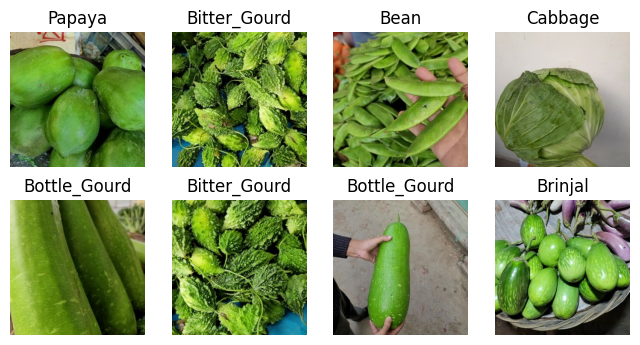

In [8]:
# Visualize a single batch of the training dataset
for images, labels in train_ds.take(1):
    class_names = train_ds.class_names
    show_images(images, labels, class_names)

## Data Preparation

First, normalize the images for both the training and validation datasets. We did this by creating a function normalize_image where every image is divided by 255 to scale them from 0 to 1. See the following cell for the codes:

In [9]:
def normalize_image(image, label):
    return image / 255.0, label

# Applying the function on both the traing and validation datasets
train_ds = train_ds.map(normalize_image)
val_ds = val_ds.map(normalize_image)

## Custom Model Training

In [10]:
# set some metrics to evaluate the model's performance
METRICS = [
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')]

For this part, we built a custom model with architecture that includes multiple layers of convolution, batch normalization, max pooling, and dense layers.
To reduce overfitting, the model uses dropout regularization with a rate of 0.4.
The model can be trained by setting the custom_trainable variable to True or loaded from pre-trained weights.

- our custom model's switch control is here.

In [11]:
num_epochs = 10
input_shape = (224, 224, 3)

custom_model = Sequential([
                    Conv2D(128, (3, 3), input_shape=input_shape, padding="same", kernel_regularizer="l2"),
                    BatchNormalization(),
                    Activation("relu"),
                    MaxPooling2D((2, 2)),
                    Conv2D(128, (3, 3), padding="same", kernel_regularizer="l2"),
                    Activation("relu"),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    Dropout(.4),
                    Conv2D(128, (3, 3), padding="same", kernel_regularizer="l2"),
                    Activation("relu"),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    Dropout(.4),
                    Flatten(),
                    Dense(128, activation='relu', kernel_regularizer="l2"),
                    Dense(15, activation="softmax")])

# use this variable to train the model or to load the model in from weights
custom_trainable = True

# Set the 'trainable' attribute to False
for layer in custom_model.layers:
    layer.trainable = custom_trainable

custom_model.build(input_shape=(None, input_shape))
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 128)    512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 activation_1 (Activation)   (None, 112, 112, 128)     0

Epoch 1/10
938/938 [==============================] - 217s 219ms/step - loss: 7.7677 - precision: 0.6316 - recall: 0.2755 - auc: 0.8394 - prc: 0.4079 - val_loss: 5.1918 - val_precision: 0.6041 - val_recall: 0.3210 - val_auc: 0.8550 - val_prc: 0.4450
Epoch 2/10
938/938 [==============================] - 204s 217ms/step - loss: 3.5592 - precision: 0.7324 - recall: 0.4501 - auc: 0.9301 - prc: 0.6401 - val_loss: 3.5215 - val_precision: 0.7308 - val_recall: 0.5240 - val_auc: 0.9249 - val_prc: 0.6673
Epoch 3/10
938/938 [==============================] - 207s 220ms/step - loss: 2.8333 - precision: 0.7610 - recall: 0.5783 - auc: 0.9585 - prc: 0.7453 - val_loss: 3.1002 - val_precision: 0.5973 - val_recall: 0.4360 - val_auc: 0.9033 - val_prc: 0.5485
Epoch 4/10
938/938 [==============================] - 206s 219ms/step - loss: 2.5704 - precision: 0.8139 - recall: 0.6796 - auc: 0.9714 - prc: 0.8257 - val_loss: 3.1115 - val_precision: 0.5996 - val_recall: 0.4063 - val_auc: 0.9125 - val_prc: 0.5413


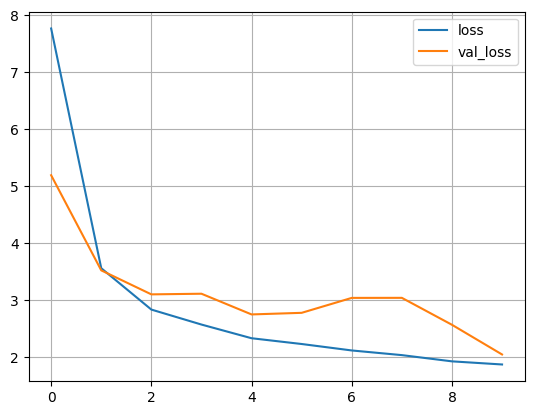

In [12]:
# Train the image classification model
custom_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=METRICS)
train_log = custom_model.fit(train_ds, validation_data=val_ds, epochs=num_epochs, batch_size=64, verbose=1)

plot_loss(train_log)

In [1]:
custom_model.save_weights('custom_weights.h5')

NameError: name 'custom_model' is not defined

In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = custom_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=-1))
    y_pred.extend(np.argmax(predictions, axis=-1))

Average AUC Score: 0.907

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       200
           1       0.82      0.98      0.90       200
           2       0.90      0.79      0.84       200
           3       0.87      0.65      0.74       200
           4       0.98      0.86      0.91       200
           5       0.99      0.54      0.70       200
           6       0.88      0.95      0.91       200
           7       0.70      0.94      0.80       200
           8       0.70      0.93      0.80       200
           9       0.72      0.91      0.80       200
          10       0.92      0.81      0.86       200
          11       0.79      0.83      0.81       200
          12       0.75      0.85      0.80       200
          13       0.95      0.80      0.87       200
          14       0.92      0.72      0.81       200

    accuracy                           0.83      3000
   macro avg       0.85      0.

<Axes: >

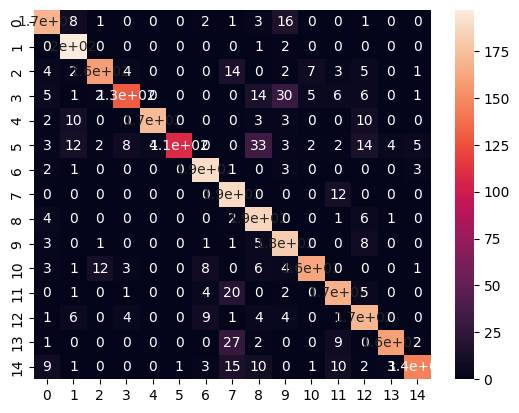

In [14]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# One-hot encode the true labels to match the predicted labels format
y_true_one_hot = np.zeros((y_true.size, y_true.max() + 1))
y_true_one_hot[np.arange(y_true.size), y_true] = 1

# Calculate AUC score
auc_scores = [roc_auc_score(y_true_one_hot[:, i], y_pred == i) for i in range(15)]
average_auc = np.mean(auc_scores)
print(f'Average AUC Score: {average_auc:.3f}\n')

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

1/1 [==============================] - 0s 23ms/step


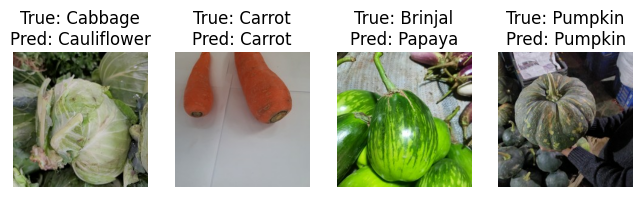

In [15]:
sample_images, sample_labels = next(iter(val_ds))
predictions = custom_model.predict(sample_images)

plt.figure(figsize=(8,4))

for i in range(4):
    image = sample_images[i].numpy()
    label = sample_labels[i].numpy()
    true_label_index = np.argmax(label)
    pred_label_index = np.argmax(predictions[i])

    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.title(f"True: {class_names[true_label_index]}\nPred: {class_names[pred_label_index]}")
    plt.axis('off')
plt.show()

## Test Best Models and Illustrate Results

In [21]:
test_dir='Vegetable Images/test'
test_ds = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size = batch_size)

Found 3000 files belonging to 15 classes.


Do the same data preparation for the testing dataset.

In [22]:
# normalize the test dataset
test_ds = test_ds.map(normalize_image)

Get predictions from the custom model on the test dataset.

In [ ]:
def veggie_classification(model, test_ds):
    y_pred = []
    
    for images, _ in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=-1))

    return np.array(y_pred)

test_predictions = veggie_classification(custom_model, test_ds)

In [ ]:
y_true_test = []
y_pred_test = []

for images, labels in test_ds:
    test_predictions = custom_model.predict(images)
    y_true_test.extend(np.argmax(labels.numpy(), axis=-1))
    y_pred_test.extend(np.argmax(test_predictions, axis=-1))

Average AUC Score: 0.900

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       200
           1       0.73      0.94      0.82       200
           2       0.82      0.84      0.83       200
           3       0.90      0.56      0.69       200
           4       0.91      0.81      0.86       200
           5       0.99      0.53      0.69       200
           6       0.88      0.96      0.92       200
           7       0.74      0.96      0.84       200
           8       0.64      0.85      0.73       200
           9       0.67      0.90      0.77       200
          10       0.91      0.80      0.85       200
          11       0.85      0.84      0.85       200
          12       0.79      0.88      0.83       200
          13       0.96      0.87      0.91       200
          14       0.91      0.67      0.77       200

    accuracy                           0.81      3000
   macro avg       0.84      0.

<Axes: >

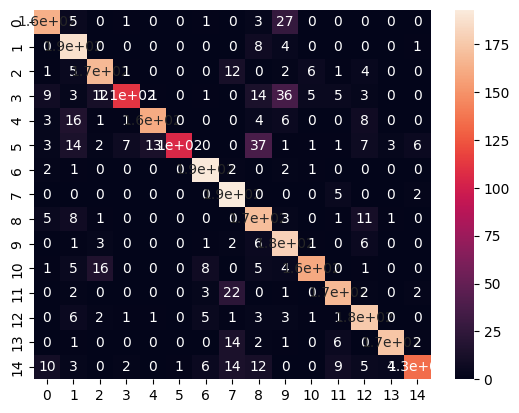

In [25]:
y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)

# One-hot encode the true labels to match the predicted labels format
y_true_one_hot_test = np.zeros((y_true_test.size, y_true_test.max() + 1))
y_true_one_hot_test[np.arange(y_true_test.size), y_true_test] = 1

# Calculate AUC score
auc_scores_test = [roc_auc_score(y_true_one_hot_test[:, i], y_pred_test == i) for i in range(15)]
average_auc_test = np.mean(auc_scores_test)
print(f'Average AUC Score: {average_auc_test:.3f}\n')

# Print classification report
print('Classification Report:')
print(classification_report(y_true_test, y_pred_test))
sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True)

Get sample images with their true labels and the custom model's predicted label.

1/1 [==============================] - 0s 27ms/step


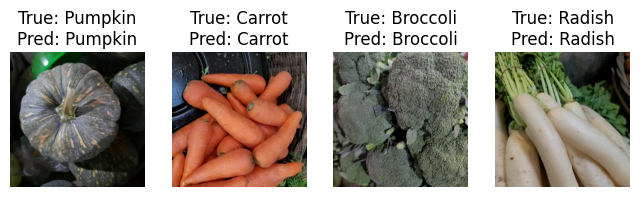

In [29]:
sample_images, sample_labels = next(iter(test_ds))
predictions = custom_model.predict(sample_images)

plt.figure(figsize=(8,4))

for i in range(4):
    image = sample_images[i].numpy()
    label = sample_labels[i].numpy()
    true_label_index = np.argmax(label)
    pred_label_index = np.argmax(predictions[i])

    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.title(f"True: {class_names[true_label_index]}\nPred: {class_names[pred_label_index]}")
    plt.axis('off')
plt.show()

## Conclusion

- We can conclude that VGG16 model significantly outperforms custom model in terms of classification performance.

- VGG16 model has an average AUC score of 0.994 compared to our custom model average AUC score of 0.900, indicating that VGG16 model has a better ability to distinguish between classes.

- Additionally, the accuracy, precision, recall, and F1-scores for VGG16 model are consistently higher across all classes than those for custom model.

- on overall accuracy, VGG16 model has correctly classifies 99%, while custom model has an accuracy of 81%.

- Therefore, VGG16 model demonstrates superior performance compared to custom model, VGG16 is the better choice for veggie classification.